In [1]:
import sys
sys.path.append('../src')

from module.module import Linear
from module.activation import TanH, Sigmoide

from loss.loss import BCELoss
from networks.optim import Optim
from networks.sequentiel import Sequentiel

from utils.generation import generate_linear_data, generate_data_gauss
from utils.plots import plot_net, visualization, plot_usps_predictions
from utils.evaluation import accuracy

from sklearn.cluster import KMeans

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

In [2]:
data = pkl.load(open("../data/usps.pkl",'rb')) 

In [3]:
X_train = data["X_train"]
y_train = data["Y_train"]

X_test = data["X_test"]
y_test = data["Y_test"]

100%|██████████| 100/100 [00:50<00:00,  1.97it/s]

Training completed.


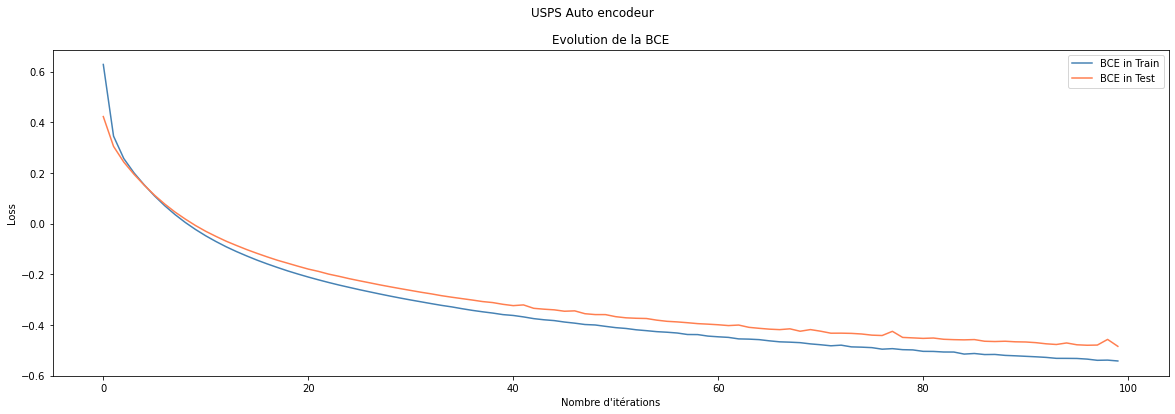

In [5]:
input_neurons = 256
h1 = 160
h2 = 120
h3 = 60
h4 = 10

encoder = [
    Linear(input_neurons, h1, bias=True, init="uniform"),
    TanH(),
    Linear(h1, h2, bias=True, init="uniform"),
    TanH(),
    Linear(h2, h3, bias=True, init="uniform"),
    TanH(),
    Linear(h3, h4, bias=True, init="uniform"),
    TanH()
]

decoder = [
    Linear(h4, h3, bias=True, init="uniform"),
    TanH(),
    Linear(h3, h2, bias=True, init="uniform"),
    TanH(),
    Linear(h2, h1, bias=True, init="uniform"),
    TanH(),
    Linear(h1, input_neurons, bias=True, init="uniform"),
    Sigmoide()
]

net = Sequentiel([*encoder, *decoder])

optim = Optim(net, BCELoss(), eps=1e-5)
optim.SGD(X_train, X_train, test_train_split=True, batch_size=100, epochs=100, verbose=False)

plot_net(X_train, X_train, net, optim.train_loss, test_loss=optim.test_loss, net_type="auto_encodeur", net_title="USPS Auto encodeur", loss_name="BCE")
Xhat = net(X_train)

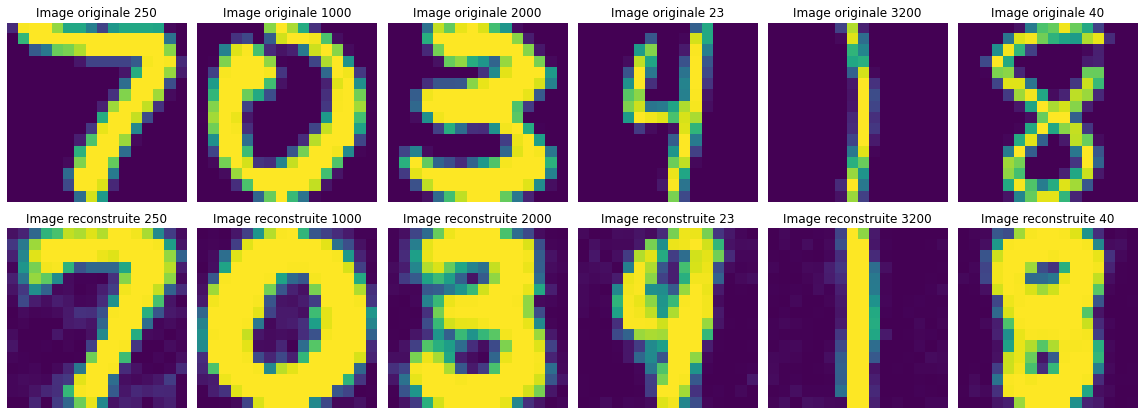

In [18]:
plot_usps_predictions(X_train, Xhat, [250, 1000, 2000, 23, 3200, 40])

In [19]:
encoder_net = Sequentiel(encoder)
x_encoder = encoder_net(X_train)

kmeans = KMeans(n_clusters=10, random_state=0)

labels = kmeans.fit_predict(x_encoder)

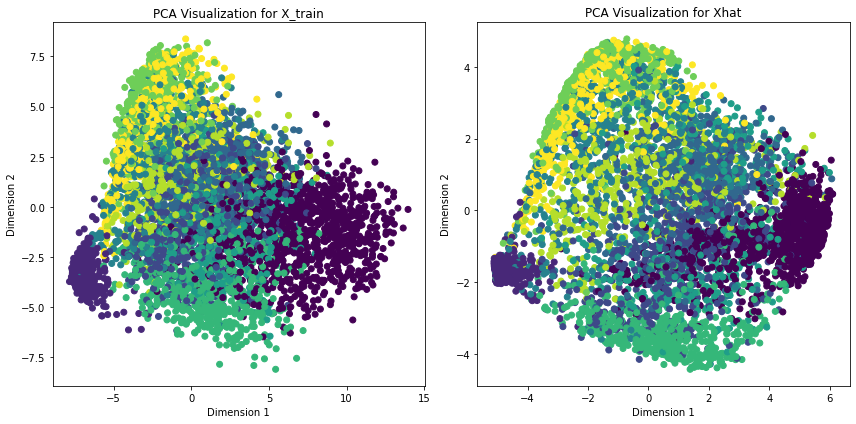

In [20]:
visualization(X_train, Xhat, y_train, type_affichage="pca", n_components=2)

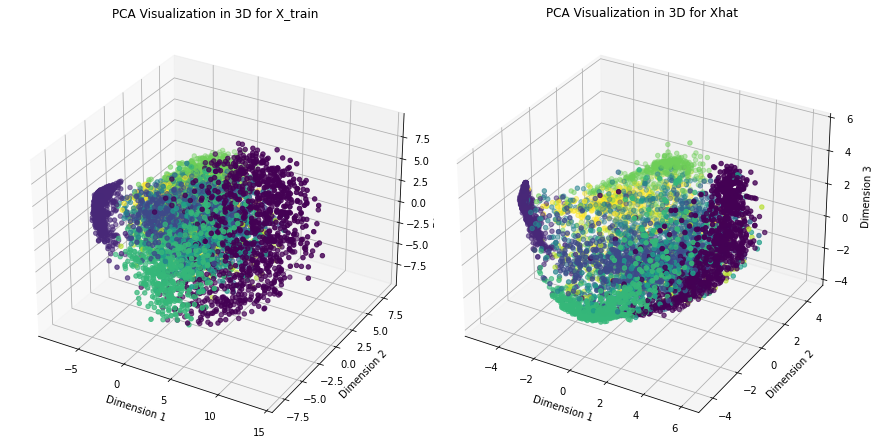

In [21]:
visualization(X_train, Xhat, y_train, type_affichage="pca", n_components=3)

/home/amayas/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/amayas/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/amayas/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/amayas/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


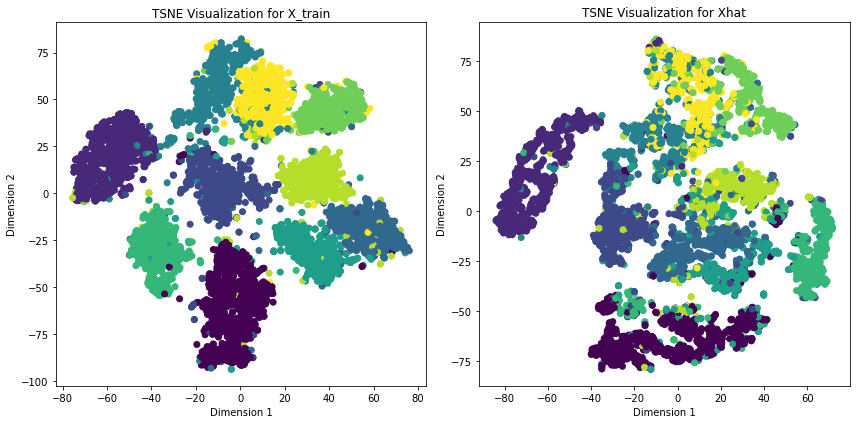

In [22]:
visualization(X_train, Xhat, y_train, type_affichage="tsne", n_components=2)